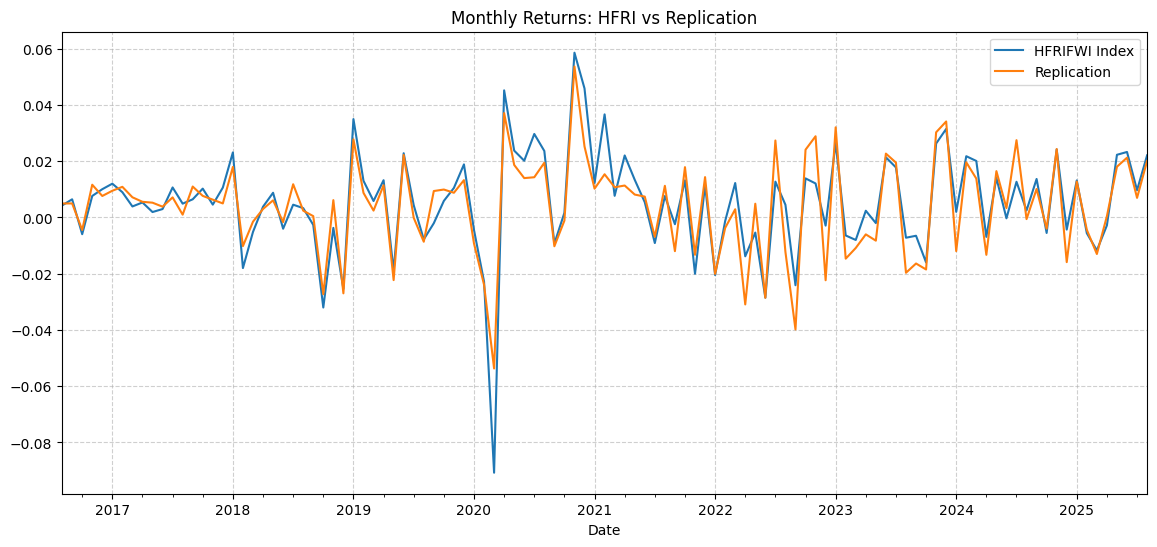

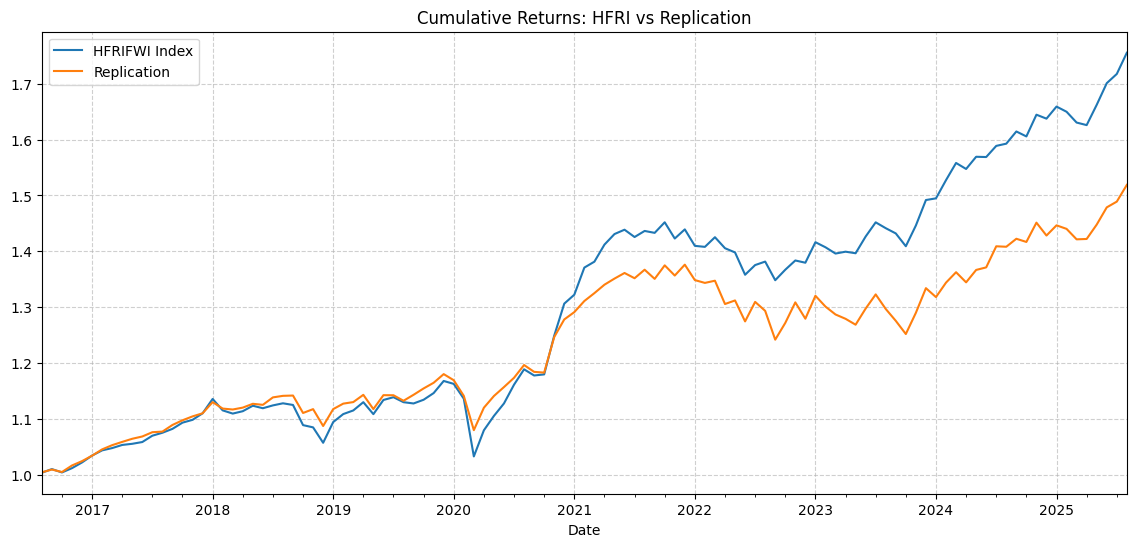

OOS R-squared: 0.8055

Correlation matrix:
               HFRIFWI Index  Replication
HFRIFWI Index          1.000        0.901
Replication            0.901        1.000


In [7]:
#(Q7)
import pandas as pdimport numpy as npimport statsmodels.api as smimport matplotlib.pyplot as pltfrom statsmodels.regression.rolling import RollingOLS
xls_path = "proshares_analysis_data.xlsx"
hf_series = pd.read_excel(xls_path, sheet_name="hedge_fund_series")
merrill_factors = pd.read_excel(xls_path, sheet_name="merrill_factors")

hf_series = hf_series.rename(columns={"Unnamed: 0": "Date"}).set_index("Date")
merrill_factors = merrill_factors.rename(columns={"Unnamed: 0": "Date"}).set_index("Date")
hf_series.index = pd.to_datetime(hf_series.index)
merrill_factors.index = pd.to_datetime(merrill_factors.index)

hf_series = hf_series.loc[merrill_factors.index].dropna()
merrill_factors = merrill_factors.loc[hf_series.index]

#Rolling OLS replication
t = 60
n = len(hf_series)
data = hf_series[['HFRIFWI Index']].copy()
data['Replication'] = np.nan

for i in range(t, n):
    y = hf_series['HFRIFWI Index'].iloc[i-t:i]
    x = sm.add_constant(merrill_factors).iloc[i-t:i]
    m = sm.OLS(y, x).fit()
    oos_val = sm.add_constant(merrill_factors).iloc[i].to_numpy().reshape(7)
    data.iloc[i, 1] = m.predict(oos_val)

#Plot actual vs replication and cumulative
ax = data.dropna().plot(figsize=(14,6), title="Monthly Returns: HFRI vs Replication")
plt.grid(True, linestyle='--', alpha=0.6)
(1 + data.dropna()).cumprod().plot(figsize=(14,6), title="Cumulative Returns: HFRI vs Replication")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#RollingOLS shortcut
x = sm.add_constant(merrill_factors)
y = hf_series['HFRIFWI Index']

rolling = RollingOLS(y, x, window=60).fit()
rolling_betas = rolling.params
replication_rolling = (rolling_betas.shift() * x).dropna().sum(axis=1)

#OOS R-squared
oos_loss = (data.dropna().diff(axis=1)**2)['Replication'].sum()
oos_mean = data.dropna()['HFRIFWI Index'].mean()
oos_loss_null = ((data.dropna()['HFRIFWI Index'] - oos_mean)**2).sum()
oos_r2 = 1 - oos_loss / oos_loss_null
print(f"OOS R-squared: {oos_r2:.4f}")

#Correlation
print("\nCorrelation matrix:")
print(data.corr().round(3))


Our replication portfolio tracks the HFRIFWI Index reasonably well, with about 90% correlation, though it lags in cumulative returns. This suggests the factor model captures most short-term movements but misses part of the long-term alpha.

Whether to include an intercept is key: keeping it captures non-tradable alpha and improves fit; removing it limits the model to tradable betas, giving a more realistic replication. The choice depends on whether the goal is performance explanation or implementable replication.